# Testing notebook for nifty fit on atmosphere TODs directly (no image)

# Try to add a nifty model for sampling the input map

numpy version: 2.1.1


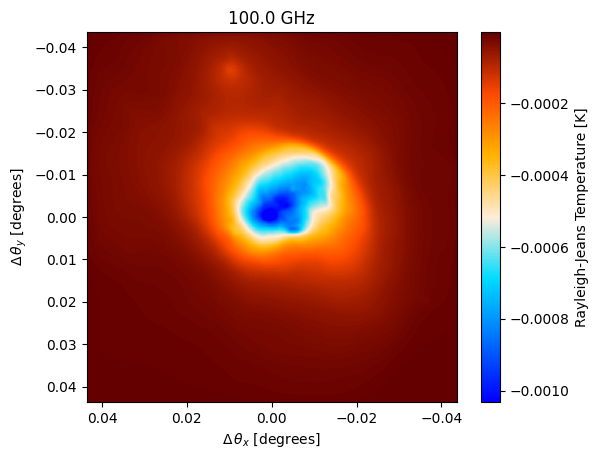

In [1]:
import numpy as np
print(f"numpy version: {np.__version__}")
import matplotlib.pyplot as plt
import maria
import sys
import os

# Relative import of sample_maps for now
sys.path.append(os.path.abspath('../python'))
import mapsampling_jax
from mapsampling_jax import sample_maps

map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=-8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()

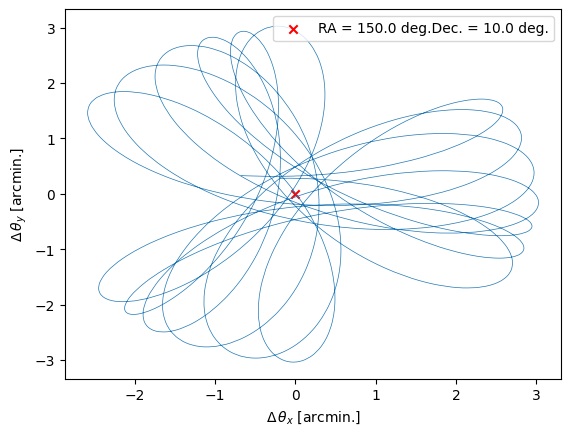

In [2]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                    #   duration=600, # integration time in seconds
                      duration=300, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

2024-10-07 11:17:26.164 INFO: Constructed instrument.
2024-10-07 11:17:26.165 INFO: Constructed plan.
2024-10-07 11:17:26.166 INFO: Constructed site.
2024-10-07 11:17:26.890 INFO: Constructed boresight.
2024-10-07 11:17:27.228 INFO: Constructed offsets.


Initialized base in 1064 ms.


Generating noise: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]
Generating atmosphere: 4it [00:00,  7.29it/s]
Sampling map (m2/f093): 100%|██████████| 1/1 [00:05<00:00,  5.63s/it]


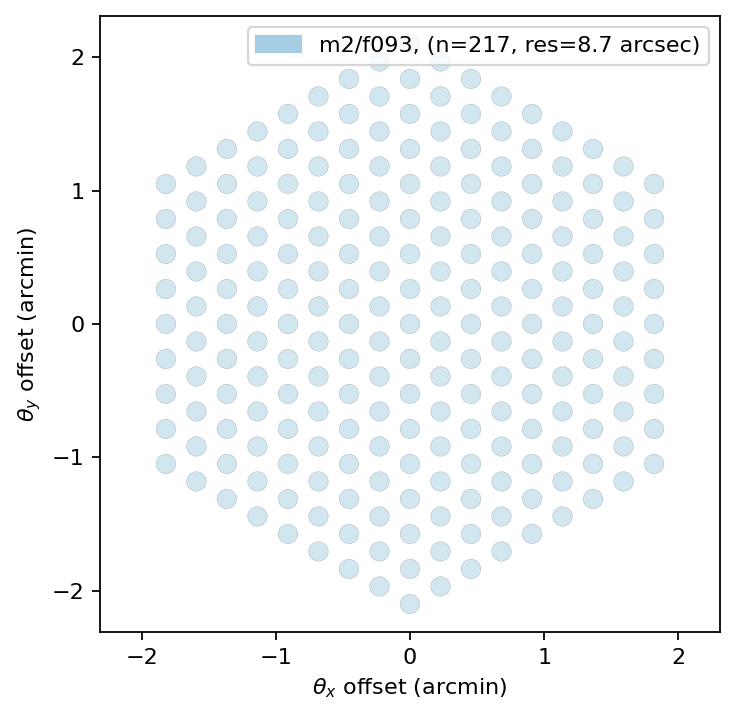

In [3]:
# instrument = maria.get_instrument('MUSTANG-2')
instrument = mapsampling_jax.instrument
instrument.plot()

sim_truthmap = maria.Simulation(instrument, 
                                plan=plan,
                                site="llano_de_chajnantor", 
                                map=input_map,
                                # noise=False,
                                atmosphere="2d",
                                # cmb="generate",
                                )

tod_truthmap = sim_truthmap.run()

In [4]:
dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)
dx = dx.compute()
dy = dy.compute()

dx

array([[-1.96311525e-04, -1.93090613e-04, -1.89763430e-04, ...,
        -4.96567154e-05, -5.29412136e-05, -5.70348442e-05],
       [-2.45439384e-04, -2.42218725e-04, -2.38891794e-04, ...,
        -9.68853867e-05, -1.00169620e-04, -1.04262934e-04],
       [-1.21122676e-04, -1.17901819e-04, -1.14574693e-04, ...,
         2.59204179e-05,  2.26359606e-05,  1.85423953e-05],
       ...,
       [ 1.21522517e-04,  1.24745513e-04,  1.28074763e-04, ...,
         2.52595530e-04,  2.49308869e-04,  2.45212641e-04],
       [-4.04799431e-04, -4.01576046e-04, -3.98246397e-04, ...,
        -2.76444410e-04, -2.79731357e-04, -2.83828042e-04],
       [-7.45700339e-04, -7.42479600e-04, -7.39152578e-04, ...,
        -5.97576858e-04, -6.00861071e-04, -6.04954460e-04]])

Running mapper (m2/f093): 100%|██████████| 1/1 [00:05<00:00,  5.29s/it]


mapdata_truth shape: (1, 1000, 1000)
mapdata_truth mean: -8.726028151723567e-05


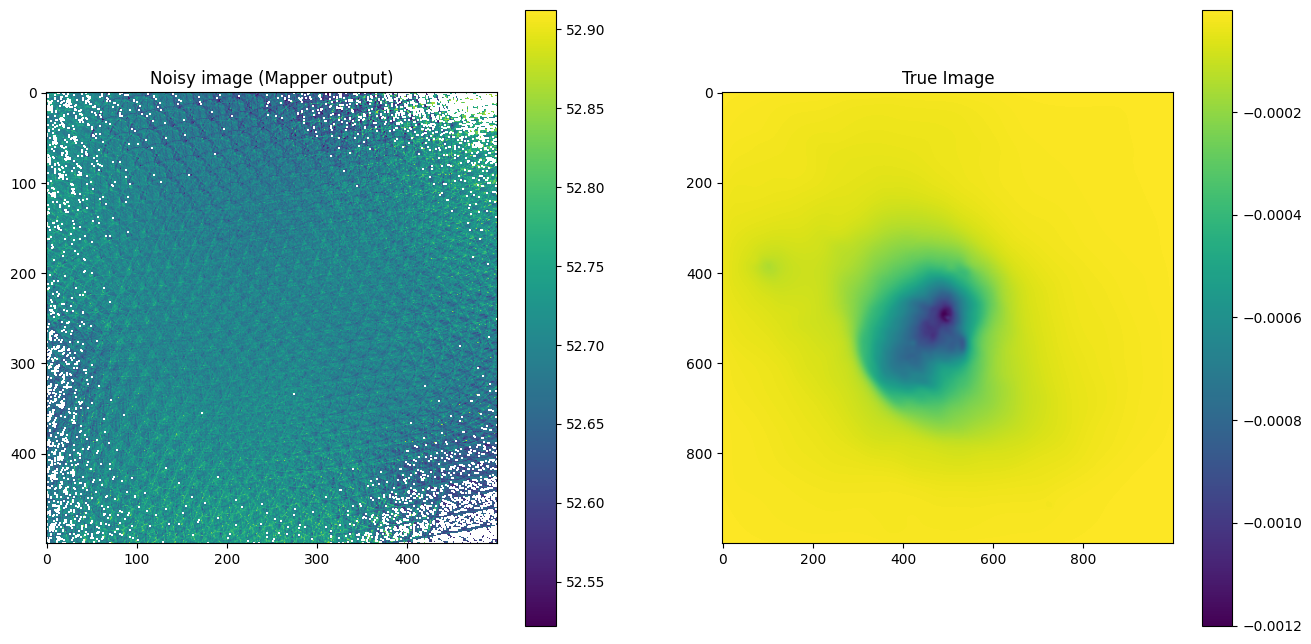

In [5]:
from maria.map.mappers import BinMapper

# Run mapper without any filtering to get noisy mimge
mapper_truthmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
mapper_truthmap.add_tods(tod_truthmap)
output_truthmap = mapper_truthmap.run()

mapdata_truth = np.float64(sim_truthmap.map.data)
mapdata_truth = np.nan_to_num(mapdata_truth, nan=np.nanmean(mapdata_truth)) # replace nan value by img mean

print("mapdata_truth shape:", mapdata_truth.shape)
print("mapdata_truth mean:", mapdata_truth.mean())

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(output_truthmap.data[0].T)
fig.colorbar(im0)
axes[0].title.set_text("Noisy image (Mapper output)")

im1 = axes[1].imshow(mapdata_truth[0])
fig.colorbar(im1)
axes[1].title.set_text("True Image")

plt.show()

# Re-implement map sampling in JAX for nifty response function:

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import jax
from jax import random
import jax.numpy as jnp

import nifty8.re as jft
import matplotlib.pyplot as plt

import numpy as np

from functools import reduce
from operator import or_

seed = 42
key = random.PRNGKey(seed)

2024-10-07 11:17:48.328 INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-10-07 11:17:48.329 INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


# Test TOD agreement:

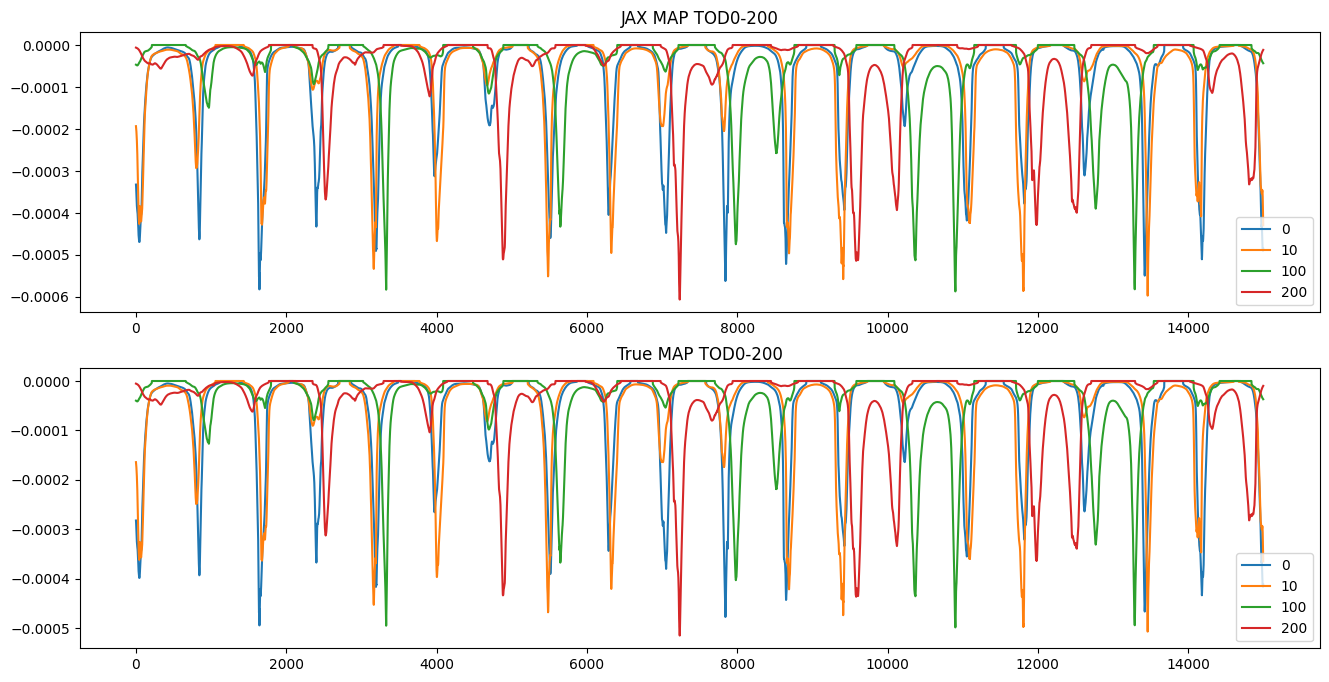

In [7]:
jax_tods = sample_maps(mapdata_truth, dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(jax_tods[i], label=i)

    tods_map = np.float64(tod_truthmap.components['map'].compute())
    im1 = axes[1].plot(tods_map[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True MAP TOD0-{i}')
axes[1].legend()

plt.show()

# Prepare noised input TODs:

Noise stddev: 0.0002490125


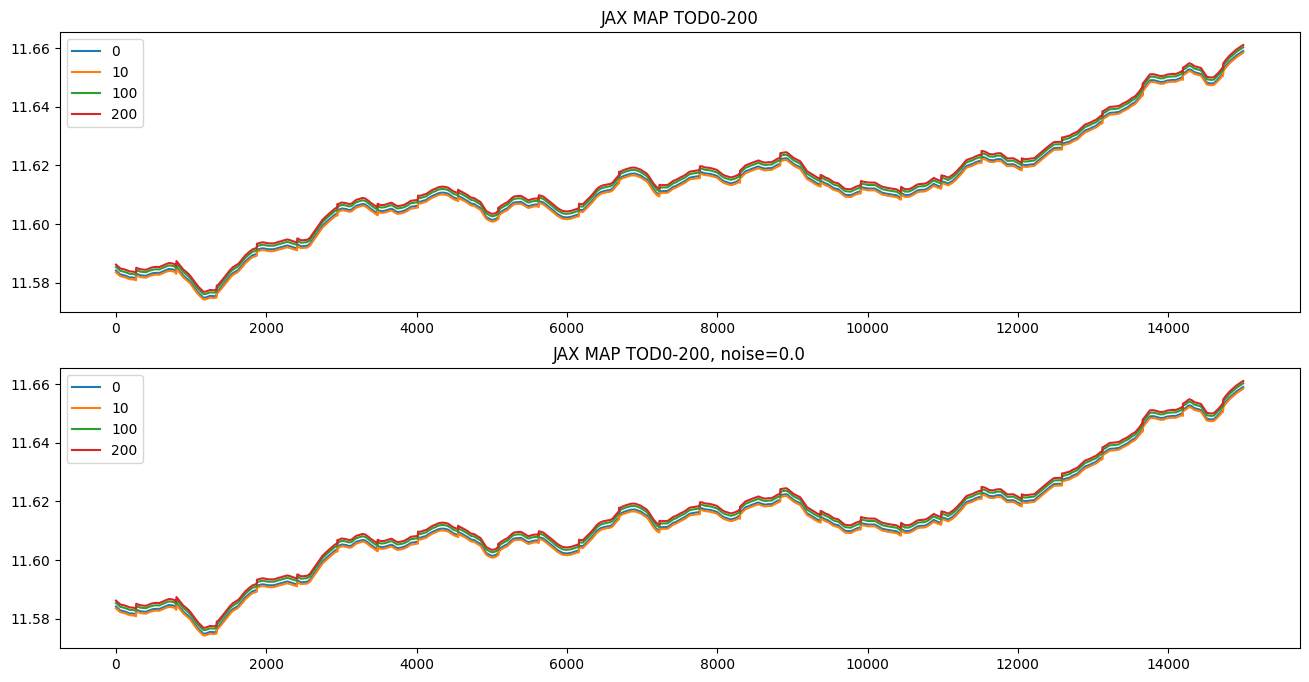

In [8]:
# Pick noise level for rest of run:
noiselevel = 0.0
# noiselevel = 0.1
# noiselevel = 0.5
# noiselevel = 1.0

# jax_tods = sample_maps(mapdata_truth, dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
jax_tods = tod_truthmap.components['atmosphere']
noised_jax_tod = np.float64(jax_tods) + np.float64(tod_truthmap.components['noise']*noiselevel)

print("Noise stddev:", np.std(tod_truthmap.components['noise'].compute()))

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(jax_tods[i], label=i)

    im1 = axes[1].plot(noised_jax_tod[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'JAX MAP TOD0-{i}, noise={noiselevel}')
axes[1].legend()

plt.show()

# Next, initialise nifty prior model

In [9]:
dims = (jax_tods.shape[1] + 1000,)
padding = dims[0] - jax_tods.shape[1]
# Map model

# correlated field zero mode GP offset and stddev
# cf_zm_map = dict(offset_mean=atmosdata_truth.mean(), offset_std=(atmosdata_truth.mean()/10., atmosdata_truth.mean()/10.))

# cf_zm_tod = dict(offset_mean=11.5, offset_std=(5.0, 5.0))
# cf_zm_tod = dict(offset_mean=0.1, offset_std=(1.0, 0.1))
cf_zm_tod = dict(offset_mean=10., offset_std=(2.0, 0.1))
# correlated field fluctuations (mostly don't need tuning)
cf_fl_tod = dict(
    # fluctuations=(1e-2, 2e-3), # fluctuations: y-offset in power spectrum in fourier space (zero mode)
    # loglogavgslope=(-5e0, 2e0), # power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
    fluctuations=(1, 0.1),
    loglogavgslope=(-3, 0.5),
    flexibility=None,
    asperity=None,
    # flexibility=(1.5e0, 5e-1), # deviation from simple power-law
    # asperity=(5e-1, 5e-2), # small scale features in power-law
)

# put together in correlated field model
cfm_tod = jft.CorrelatedFieldMaker("")
cfm_tod.set_amplitude_total_offset(**cf_zm_tod)
cfm_tod.add_fluctuations(
    dims, distances=1.0 / dims[0], **cf_fl_tod, prefix="tod ", non_parametric_kind="power"
)
# gp_tod = cfm_tod.finalize()

In [10]:
noised_jax_tod.shape

(217, 15000)

In [11]:
# init params for each TOD:
# n = 100
n = noised_jax_tod.shape[0]

gps = []
for i in range(n):
    cfmi = jft.CorrelatedFieldMaker(f'tod{i} ')
    # cfmi.set_amplitude_total_offset(**cf_zm_tod)
    cfmi._azm = cfm_tod._azm
    cfmi._offset_mean = cfm_tod._offset_mean
    cfmi._parameter_tree['zeromode'] = jft.ShapeWithDtype(())

    cfmi._fluctuations.append(cfm_tod._fluctuations[0])
    cfmi._target_grids.append(cfm_tod._target_grids[0])
    cfmi._parameter_tree.update(cfm_tod._fluctuations[0].domain)
    gps.append(cfmi.finalize())

In [12]:
# Define simple signal model with added map sampling
class Signal_TOD(jft.Model):
    def __init__(self, gps):
        # self.gp_tod = gp_tod
        # super().__init__(init=self.gp_tod.init, domain=jft.Vector(gp_tod.domain))
        self.gps = gps
        self.tgt = (len(gps), gps[0].target.size)
        super().__init__(init=reduce(or_, [gp.init for gp in gps]), domain=reduce(or_, [gp.domain for gp in gps]))
    
    def __call__(self, x):
        res = jnp.zeros(self.tgt)
        for i, gp in enumerate(self.gps):
            res = res.at[i].set(gp(x))
        
        return res[:, padding//2:-padding//2]
  
signal_response_tod = Signal_TOD(gps)

# Define noise covariance
# if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x
if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 1e-8**-2 * x
elif noiselevel == 0.1: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 0.5: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 1.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x

# Combine in likelihood - only fit 0th TOD for now!
truth = noised_jax_tod[:n]
lh_tod = jft.Gaussian( truth, noise_cov_inv_tod).amend(signal_response_tod)

# lh = lh_tod + lh_map
# lh = lh_map
lh = lh_tod

# lh_map_grad = jax.grad(lh_map)
lh_tod_grad = jax.grad(lh_tod)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


In [13]:
signal_response_tod

Signal_TOD(
	<bound method Signal_TOD.__call__>,
	domain={'tod fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'tod loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'tod0 xi': ShapeWithDtype(shape=(16000,), dtype=<class 'jax.numpy.float64'>),
	 'tod1 xi': ShapeWithDtype(shape=(16000,), dtype=<class 'jax.numpy.float64'>),
	 'tod10 xi': ShapeWithDtype(shape=(16000,), dtype=<class 'jax.numpy.float64'>),
	 'tod100 xi': ShapeWithDtype(shape=(16000,), dtype=<class 'jax.numpy.float64'>),
	 'tod101 xi': ShapeWithDtype(shape=(16000,), dtype=<class 'jax.numpy.float64'>),
	 'tod102 xi': ShapeWithDtype(shape=(16000,), dtype=<class 'jax.numpy.float64'>),
	 'tod103 xi': ShapeWithDtype(shape=(16000,), dtype=<class 'jax.numpy.float64'>),
	 'tod104 xi': ShapeWithDtype(shape=(16000,), dtype=<class 'jax.numpy.float64'>),
	 'tod105 xi': ShapeWithDtype(shape=(16000,), dtype=<class 'jax.numpy.float64'>),
	 'tod106 xi': ShapeWithDtype(shape=(16000,

# Draw Prior sample

(217, 15000)


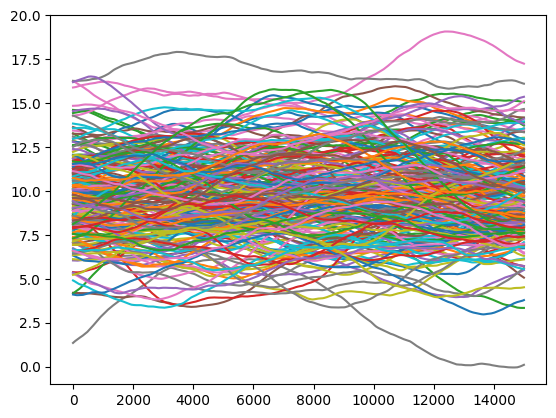

In [14]:
key, sub = jax.random.split(key)
xi = jft.random_like(sub, signal_response_tod.domain)
res = signal_response_tod(xi)
print(res.shape)

for i in range(res.shape[0]):
    plt.plot(np.arange(0, res.shape[1]), res[i])
plt.show()

# MAP fit

In [15]:
n_it = 1
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4

n_samples = 0 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60 # map
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=20 # map
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
)

OPTIMIZE_KL: Starting 0001


M: →:1.0 ↺:False #∇²:06 |↘|:2.893067e+02 ➽:3.472003e+02
M: Iteration 1 ⛰:+1.170366e+22 Δ⛰:1.184995e+23
OPTIMIZE_KL: Iteration 0001 ⛰:+1.1704e+22
OPTIMIZE_KL: #(KL minimization steps) 1
OPTIMIZE_KL: Likelihood residual(s):
'reduced χ²: 7.2e+15±     0.0, avg:   +5e+07±     0.0, #dof:3255000'

OPTIMIZE_KL: Prior residual(s):
tod fluctuations        :: 'reduced χ²:   6e+01±     0.0, avg:     -7.7±     0.0, #dof:      1'
tod loglogavgslope      :: 'reduced χ²:   0.067±     0.0, avg:    +0.26±     0.0, #dof:      1'
tod0 xi                 :: 'reduced χ²:    0.99±     0.0, avg:   -0.018±     0.0, #dof:  16000'
tod1 xi                 :: 'reduced χ²:     1.0±     0.0, avg:   +0.012±     0.0, #dof:  16000'
tod10 xi                :: 'reduced χ²:    0.98±     0.0, avg:  -0.0049±     0.0, #dof:  16000'
tod100 xi               :: 'reduced χ²:    0.99±     0.0, avg:  -0.0023±     0.0, #dof:  16000'
tod101 xi               :: 'reduced χ²:     1.0±     0.0, avg:   +0.012±     0.0, #dof:  16000'
tod1

In [16]:
samples.pos

Vector(
	{'tod fluctuations': Array(-7.72754308, dtype=float64),
	 'tod loglogavgslope': Array(0.2597285, dtype=float64),
	 'tod0 xi': Array([ 1.3013162 ,  1.71153507, -0.5853421 , ..., -0.88770754,
	       -1.04909081, -0.503381  ], dtype=float64),
	 'tod1 xi': Array([ 0.35456292,  0.24323906, -0.1650556 , ...,  1.18510565,
	        0.76063083,  1.26732973], dtype=float64),
	 'tod10 xi': Array([ 1.23774268, -0.084151  ,  0.06013258, ...,  1.35901959,
	       -0.13567335,  0.85294509], dtype=float64),
	 'tod100 xi': Array([ 0.41630146,  1.32620864,  1.1628349 , ...,  0.77106066,
	        0.25946817, -0.8731145 ], dtype=float64),
	 'tod101 xi': Array([ 1.09028239,  0.36826231,  1.36564926, ..., -0.18581921,
	       -0.51819418, -0.56953634], dtype=float64),
	 'tod102 xi': Array([ 0.65958738, -0.48577181,  1.04233597, ...,  0.13731314,
	       -0.3000091 ,  0.03515547], dtype=float64),
	 'tod103 xi': Array([ 0.61981331, -0.48528172,  0.7959388 , ...,  0.126608  ,
	       -0.26695521, -0.

In [17]:
def printfitresults():
    print("Fit Results (res, init, std)")
    print(f"fluctuations: {jft.LogNormalPrior(*cf_fl_tod['fluctuations'])(samples.pos['tod fluctuations'])}, {cf_fl_tod['fluctuations'][0]}, {cf_fl_tod['fluctuations'][1]}")
    print(f"loglogvarslope: {jft.NormalPrior(*cf_fl_tod['loglogavgslope'])(samples.pos['tod loglogavgslope'])}, {cf_fl_tod['loglogavgslope'][0]}, {cf_fl_tod['loglogavgslope'][1]}")
    print(f"zeromode: {jft.LogNormalPrior(cf_zm_tod['offset_mean'], cf_zm_tod['offset_std'][0])(samples.pos['zeromode'])}, {cf_zm_tod['offset_mean']}, {cf_zm_tod['offset_std'][0]}")
    # for i in range(n):
    #     test = samples.pos[f"tod{i} zeromode"]
    #     print(f"tod{i} zeromode: {jft.LogNormalPrior(cf_zm_tod['offset_mean'], cf_zm_tod['offset_std'][0])(test)}, {cf_zm_tod['offset_mean']}, {cf_zm_tod['offset_std'][0]}")
    
printfitresults()

Fit Results (res, init, std)
fluctuations: 0.4603316911358244, 1, 0.1
loglogvarslope: -2.8701357515758, -3, 0.5
zeromode: 1.7068337382366476, 10.0, 2.0


(217, 15000)


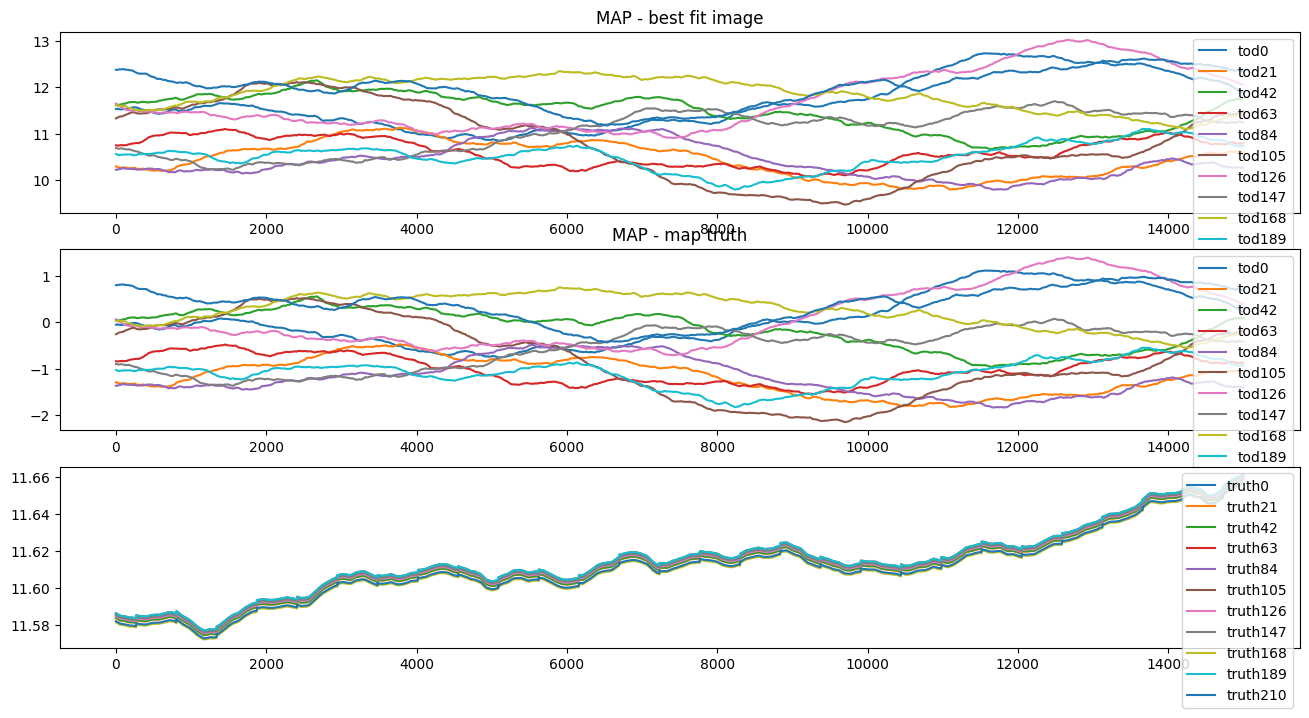

In [18]:
res = signal_response_tod(samples.pos)
print(res.shape)

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

for i in range(0, res.shape[0], res.shape[0]//10):
    im0 = axes[0].plot(np.arange(0, res.shape[1]), res[i], label=f"tod{i}")
    im1 = axes[1].plot(np.arange(0, res.shape[1]), res[i] - truth[i], label=f"tod{i}")
    im2 = axes[2].plot(truth[i], label=f"truth{i}")

axes[0].title.set_text('MAP - best fit image')
axes[0].legend()
axes[1].title.set_text('MAP - map truth')
axes[1].legend()
axes[2].legend()

plt.show()

In [19]:
# assert False

## Full nifty fit:

OPTIMIZE_KL: Starting 0001


SL: Iteration 0 ⛰:+7.7562e+22 Δ⛰:inf ➽:3.4720e-01
SL: Iteration 1 ⛰:+1.3374e+22 Δ⛰:6.4188e+22 ➽:3.4720e-01
SL: Iteration 2 ⛰:+5.2056e+21 Δ⛰:8.1684e+21 ➽:3.4720e-01
SL: Iteration 3 ⛰:+2.7341e+21 Δ⛰:2.4715e+21 ➽:3.4720e-01
SL: Iteration 4 ⛰:+2.0117e+21 Δ⛰:7.2239e+20 ➽:3.4720e-01
SL: Iteration 5 ⛰:+1.4227e+21 Δ⛰:5.8894e+20 ➽:3.4720e-01
SL: Iteration 6 ⛰:+1.2286e+21 Δ⛰:1.9416e+20 ➽:3.4720e-01
SL: Iteration 7 ⛰:+6.2603e+20 Δ⛰:6.0256e+20 ➽:3.4720e-01
SL: Iteration 8 ⛰:+6.0474e+20 Δ⛰:2.1284e+19 ➽:3.4720e-01
SL: Iteration 9 ⛰:+3.9257e+20 Δ⛰:2.1217e+20 ➽:3.4720e-01
SL: Iteration 10 ⛰:+3.0547e+20 Δ⛰:8.7096e+19 ➽:3.4720e-01
SL: Iteration 11 ⛰:+2.8570e+20 Δ⛰:1.9769e+19 ➽:3.4720e-01
SL: Iteration 12 ⛰:+2.2900e+20 Δ⛰:5.6707e+19 ➽:3.4720e-01
SL: Iteration 13 ⛰:+1.4603e+20 Δ⛰:8.2963e+19 ➽:3.4720e-01
SL: Iteration 14 ⛰:+1.3173e+20 Δ⛰:1.4301e+19 ➽:3.4720e-01
SL: Iteration 15 ⛰:+1.3158e+20 Δ⛰:1.4910e+17 ➽:3.4720e-01
SL: Iteration 16 ⛰:+9.6213e+19 Δ⛰:3.5371e+19 ➽:3.4720e-01
SL: Iteration 17 ⛰:+9.0785e+19 

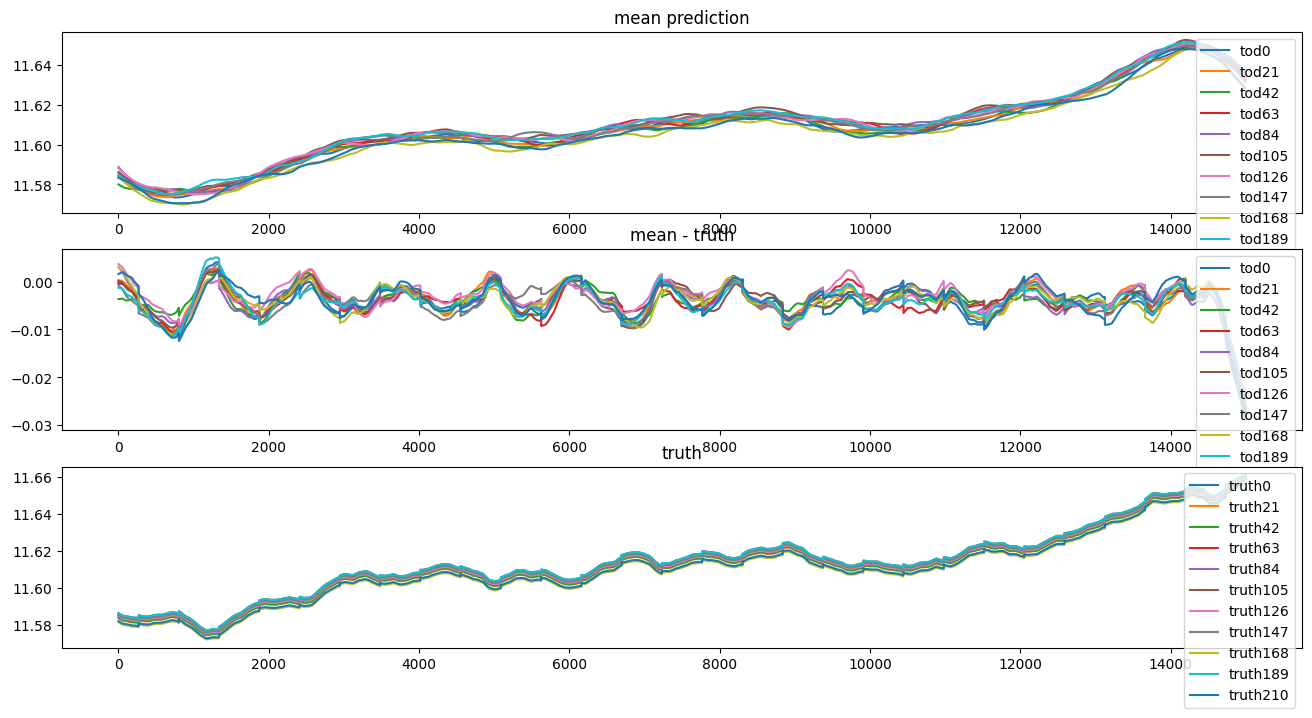

OPTIMIZE_KL: Starting 0002
SL: Iteration 0 ⛰:+3.0185e+20 Δ⛰:inf ➽:3.4720e-01
SL: Iteration 1 ⛰:+2.5377e+20 Δ⛰:4.8085e+19 ➽:3.4720e-01
SL: Iteration 2 ⛰:+2.9185e+19 Δ⛰:2.2459e+20 ➽:3.4720e-01
SL: Iteration 3 ⛰:+2.5921e+18 Δ⛰:2.6592e+19 ➽:3.4720e-01
SL: Iteration 4 ⛰:+2.2969e+18 Δ⛰:2.9527e+17 ➽:3.4720e-01
SL: Iteration 5 ⛰:+1.9209e+18 Δ⛰:3.7592e+17 ➽:3.4720e-01
SL: Iteration 6 ⛰:+1.8433e+18 Δ⛰:7.7621e+16 ➽:3.4720e-01
SL: Iteration 7 ⛰:+1.8418e+18 Δ⛰:1.5314e+15 ➽:3.4720e-01
SL: Iteration 8 ⛰:+5.0542e+17 Δ⛰:1.3364e+18 ➽:3.4720e-01
SL: Iteration 9 ⛰:+4.6466e+17 Δ⛰:4.0753e+16 ➽:3.4720e-01
SL: Iteration 10 ⛰:+2.3071e+17 Δ⛰:2.3396e+17 ➽:3.4720e-01
SL: Iteration 11 ⛰:+2.2318e+17 Δ⛰:7.5276e+15 ➽:3.4720e-01
SL: Iteration 12 ⛰:+2.2289e+17 Δ⛰:2.9415e+14 ➽:3.4720e-01
SL: Iteration 13 ⛰:+1.4619e+17 Δ⛰:7.6696e+16 ➽:3.4720e-01
SL: Iteration 14 ⛰:+1.3413e+17 Δ⛰:1.2058e+16 ➽:3.4720e-01
SL: Iteration 15 ⛰:+1.1109e+17 Δ⛰:2.3037e+16 ➽:3.4720e-01
SL: Iteration 16 ⛰:+6.5799e+16 Δ⛰:4.5296e+16 ➽:3.4720e-01
SL: 

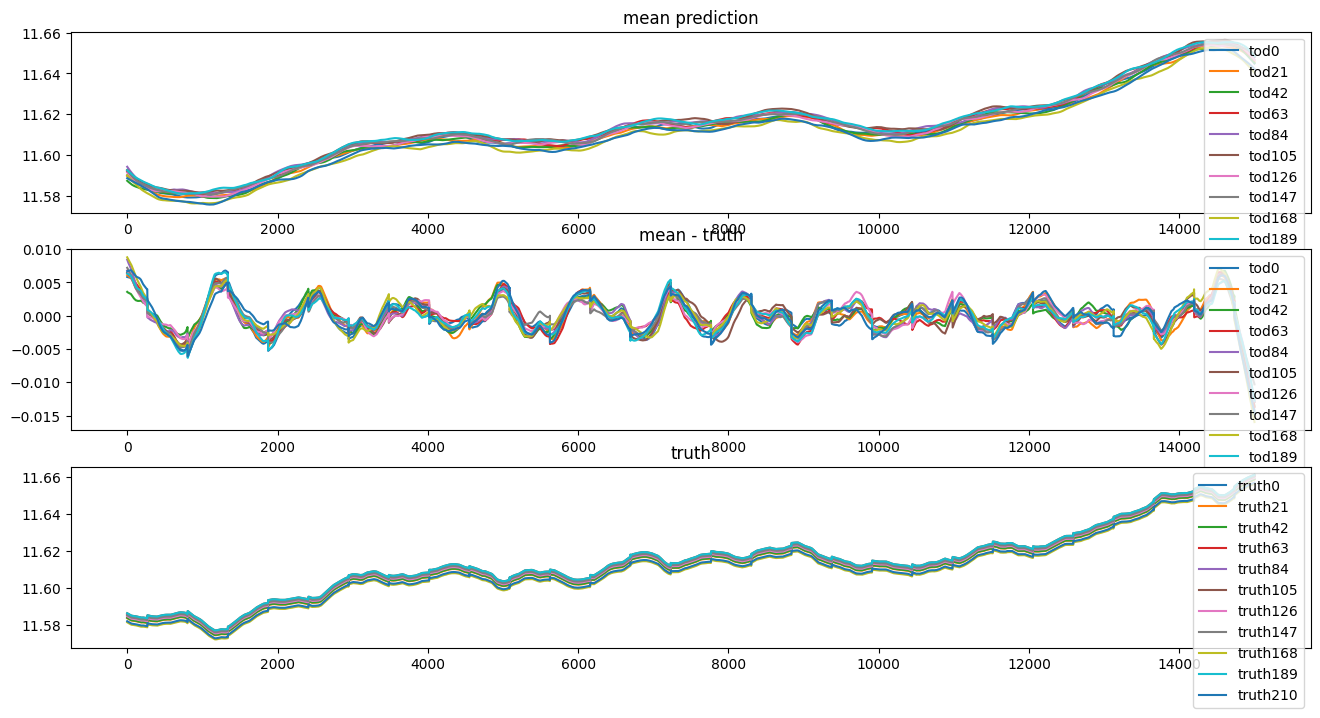

OPTIMIZE_KL: Starting 0003
SL: Iteration 0 ⛰:+3.4635e+20 Δ⛰:inf ➽:3.4720e-01
SL: Iteration 1 ⛰:+2.6595e+20 Δ⛰:8.0400e+19 ➽:3.4720e-01
SL: Iteration 2 ⛰:+3.6734e+19 Δ⛰:2.2922e+20 ➽:3.4720e-01
SL: Iteration 3 ⛰:+3.1583e+18 Δ⛰:3.3575e+19 ➽:3.4720e-01
SL: Iteration 4 ⛰:+2.7556e+18 Δ⛰:4.0274e+17 ➽:3.4720e-01
SL: Iteration 5 ⛰:+2.2315e+18 Δ⛰:5.2411e+17 ➽:3.4720e-01
SL: Iteration 6 ⛰:+1.1979e+18 Δ⛰:1.0336e+18 ➽:3.4720e-01
SL: Iteration 7 ⛰:+7.7844e+17 Δ⛰:4.1943e+17 ➽:3.4720e-01
SL: Iteration 8 ⛰:+5.2339e+17 Δ⛰:2.5505e+17 ➽:3.4720e-01
SL: Iteration 9 ⛰:+5.0091e+17 Δ⛰:2.2477e+16 ➽:3.4720e-01
SL: Iteration 10 ⛰:+2.6591e+17 Δ⛰:2.3501e+17 ➽:3.4720e-01
SL: Iteration 11 ⛰:+1.6815e+17 Δ⛰:9.7764e+16 ➽:3.4720e-01
SL: Iteration 12 ⛰:+1.6805e+17 Δ⛰:9.1530e+13 ➽:3.4720e-01
SL: Iteration 13 ⛰:+1.5741e+17 Δ⛰:1.0641e+16 ➽:3.4720e-01
SL: Iteration 14 ⛰:+1.4967e+17 Δ⛰:7.7450e+15 ➽:3.4720e-01
SL: Iteration 15 ⛰:+1.1119e+17 Δ⛰:3.8479e+16 ➽:3.4720e-01
SL: Iteration 16 ⛰:+9.7840e+16 Δ⛰:1.3349e+16 ➽:3.4720e-01
SL: 

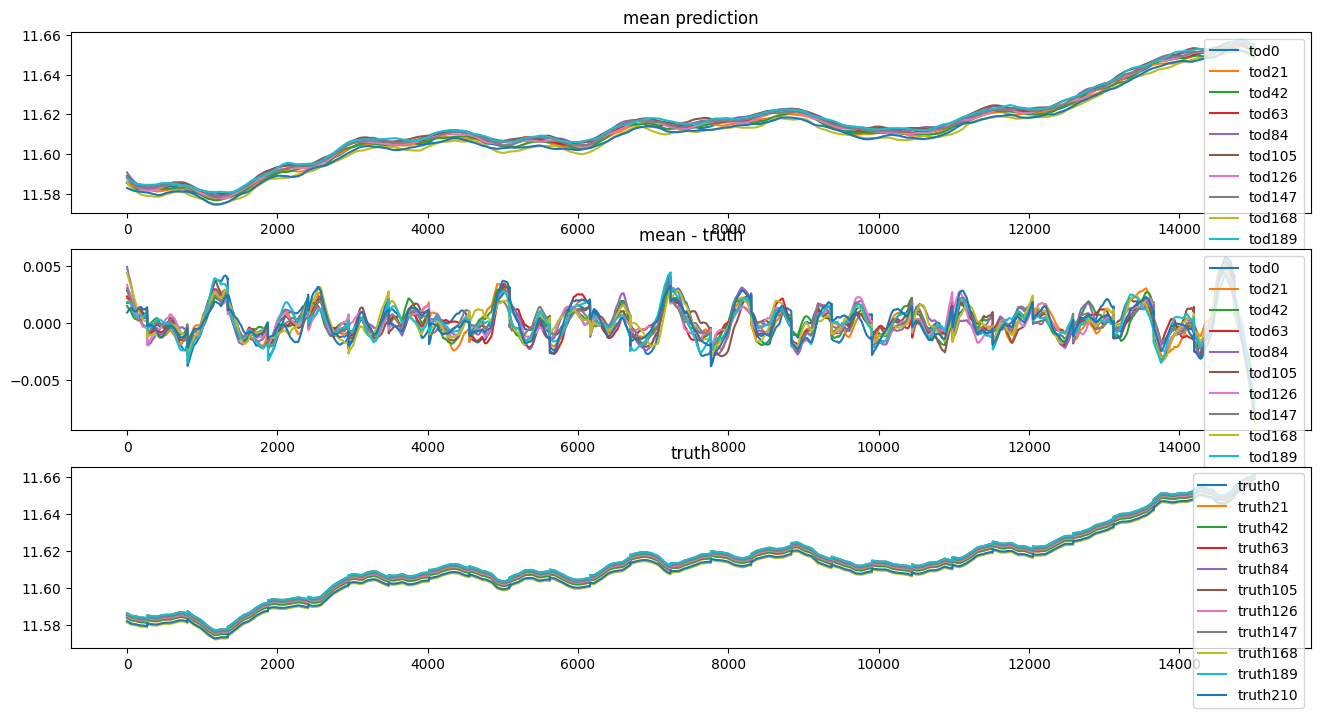

OPTIMIZE_KL: Starting 0004
SL: Iteration 0 ⛰:+6.4877e+20 Δ⛰:inf ➽:3.4720e-01
SL: Iteration 1 ⛰:+2.7561e+20 Δ⛰:3.7316e+20 ➽:3.4720e-01
SL: Iteration 2 ⛰:+4.3930e+19 Δ⛰:2.3168e+20 ➽:3.4720e-01
SL: Iteration 3 ⛰:+3.4830e+18 Δ⛰:4.0447e+19 ➽:3.4720e-01
SL: Iteration 4 ⛰:+2.8612e+18 Δ⛰:6.2185e+17 ➽:3.4720e-01
SL: Iteration 5 ⛰:+1.5614e+18 Δ⛰:1.2997e+18 ➽:3.4720e-01
SL: Iteration 6 ⛰:+1.2206e+18 Δ⛰:3.4085e+17 ➽:3.4720e-01
SL: Iteration 7 ⛰:+1.1323e+18 Δ⛰:8.8272e+16 ➽:3.4720e-01
SL: Iteration 8 ⛰:+7.1632e+17 Δ⛰:4.1600e+17 ➽:3.4720e-01
SL: Iteration 9 ⛰:+6.8267e+17 Δ⛰:3.3654e+16 ➽:3.4720e-01
SL: Iteration 10 ⛰:+3.4831e+17 Δ⛰:3.3435e+17 ➽:3.4720e-01
SL: Iteration 11 ⛰:+2.1849e+17 Δ⛰:1.2983e+17 ➽:3.4720e-01
SL: Iteration 12 ⛰:+2.1842e+17 Δ⛰:6.2945e+13 ➽:3.4720e-01
SL: Iteration 13 ⛰:+2.1661e+17 Δ⛰:1.8170e+15 ➽:3.4720e-01
SL: Iteration 14 ⛰:+2.1523e+17 Δ⛰:1.3732e+15 ➽:3.4720e-01
SL: Iteration 15 ⛰:+1.5657e+17 Δ⛰:5.8662e+16 ➽:3.4720e-01
SL: Iteration 16 ⛰:+9.5556e+16 Δ⛰:6.1017e+16 ➽:3.4720e-01
SL: 

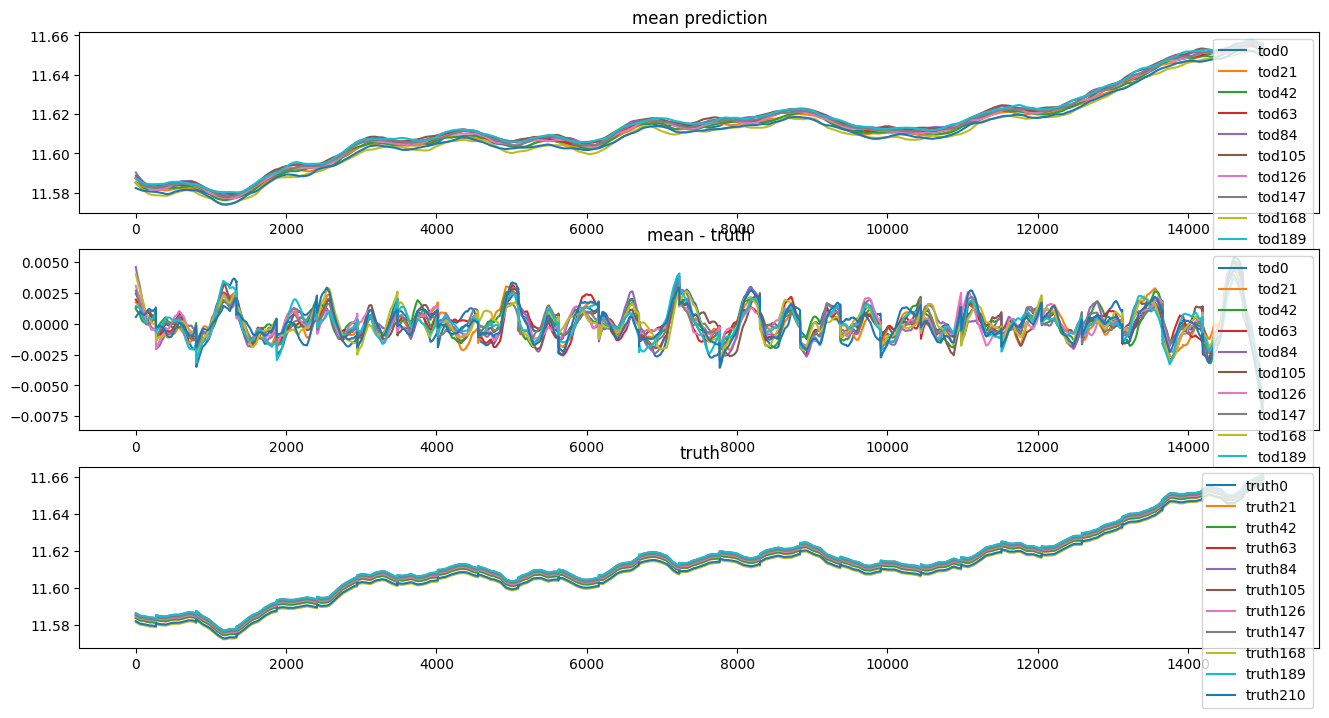

OPTIMIZE_KL: Starting 0005
SL: Iteration 0 ⛰:+5.4521e+20 Δ⛰:inf ➽:3.4720e-01
SL: Iteration 1 ⛰:+2.9622e+20 Δ⛰:2.4899e+20 ➽:3.4720e-01
SL: Iteration 2 ⛰:+4.5099e+19 Δ⛰:2.5112e+20 ➽:3.4720e-01
SL: Iteration 3 ⛰:+4.4626e+18 Δ⛰:4.0636e+19 ➽:3.4720e-01
SL: Iteration 4 ⛰:+3.8095e+18 Δ⛰:6.5312e+17 ➽:3.4720e-01
SL: Iteration 5 ⛰:+2.8559e+18 Δ⛰:9.5359e+17 ➽:3.4720e-01
SL: Iteration 6 ⛰:+2.1552e+18 Δ⛰:7.0072e+17 ➽:3.4720e-01
SL: Iteration 7 ⛰:+1.9426e+18 Δ⛰:2.1267e+17 ➽:3.4720e-01
SL: Iteration 8 ⛰:+7.6367e+17 Δ⛰:1.1789e+18 ➽:3.4720e-01
SL: Iteration 9 ⛰:+7.3951e+17 Δ⛰:2.4161e+16 ➽:3.4720e-01
SL: Iteration 10 ⛰:+3.8358e+17 Δ⛰:3.5593e+17 ➽:3.4720e-01
SL: Iteration 11 ⛰:+2.2892e+17 Δ⛰:1.5466e+17 ➽:3.4720e-01
SL: Iteration 12 ⛰:+2.2876e+17 Δ⛰:1.6418e+14 ➽:3.4720e-01
SL: Iteration 13 ⛰:+2.2717e+17 Δ⛰:1.5852e+15 ➽:3.4720e-01
SL: Iteration 14 ⛰:+2.2562e+17 Δ⛰:1.5527e+15 ➽:3.4720e-01
SL: Iteration 15 ⛰:+1.7217e+17 Δ⛰:5.3454e+16 ➽:3.4720e-01
SL: Iteration 16 ⛰:+1.0031e+17 Δ⛰:7.1859e+16 ➽:3.4720e-01
SL: 

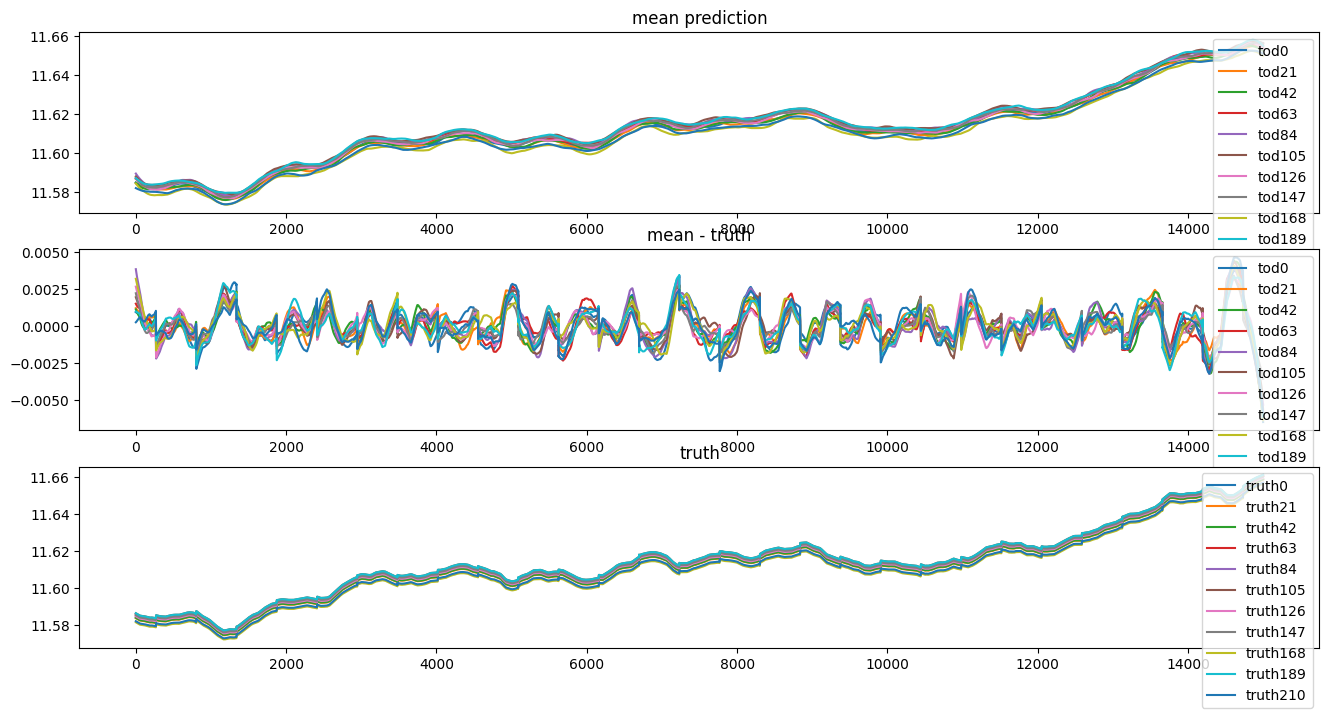

In [20]:
# n_it = 1
n_it = 5
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-6
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4
n_samples = 4 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

# callback fn for plotting during optimisation:
def callback(samples, opt_state):
    mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

    fig, axes = plt.subplots(3, 1, figsize=(16, 8))

    for i in range(0, mean.shape[0], mean.shape[0]//10):
        im0 = axes[0].plot(np.arange(0, mean.shape[1]), mean[i], label=f"tod{i}")
        im1 = axes[1].plot(np.arange(0, mean.shape[1]), mean[i] - truth[i], label=f"tod{i}")
        im2 = axes[2].plot(truth[i], label=f"truth{i}")

    axes[0].title.set_text('mean prediction')
    axes[0].legend()
    axes[1].title.set_text('mean - truth')
    axes[1].legend()
    axes[2].title.set_text('truth')
    axes[2].legend()

    plt.show()
    

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
        # cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=10),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=10
        )
    ),
    # sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
    sample_mode = lambda x: "nonlinear_resample" if x >= 1 else "linear_resample",
    callback=callback,
)

In [21]:
printfitresults()

Fit Results (res, init, std)
fluctuations: 0.070994503475189, 1, 0.1
loglogvarslope: -4.080522402321763, -3, 0.5
zeromode: 0.00014183275710565697, 10.0, 2.0


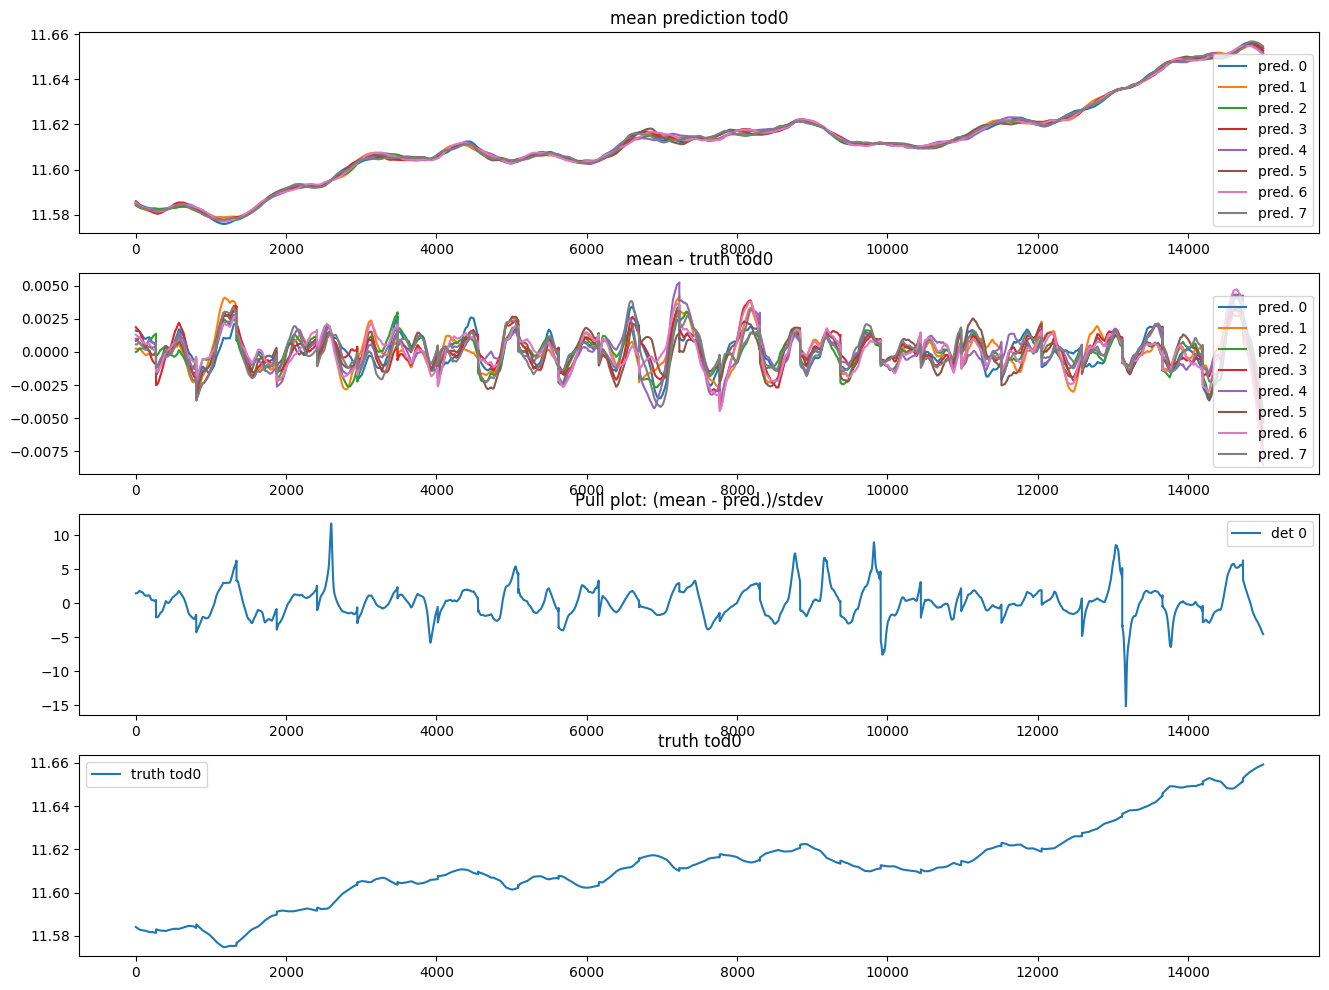

In [22]:
mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
i = 0
j = 0
# for i in range(mean.shape[0]):
for s in samples:
    pred = signal_response_tod(s)
    
    im0 = axes[0].plot(np.arange(0, pred.shape[1]), pred[i], label=f"pred. {j}")
    im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - truth[i], label=f"pred. {j}")
    j += 1

im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - truth[i])/std[i], label=f"det {i}")
im3 = axes[3].plot(truth[i], label=f"truth tod{i}")
axes[0].title.set_text(f"mean prediction tod{i}")
axes[0].legend()
axes[1].title.set_text(f"mean - truth tod{i}")
axes[1].legend()
axes[2].title.set_text(f"Pull plot: (mean - pred.)/stdev")
axes[2].legend()
axes[3].title.set_text(f"truth tod{i}")
axes[3].legend()

plt.show()